# Hierarchical linear regression for the radon dataset

Based on https://twiecki.io/blog/2014/03/17/bayesian-glms-3/
and https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/

This code uses [blackjax](https://github.com/blackjax-devs/blackjax) for MCMC inference. See also these alternative (deprecated) implementations.
- [pymc3, centered](https://github.com/probml/pyprobml/blob/master/notebooks/book2/15/linreg_hierarchical_pymc3.ipynb)
- [pymc3, noncentered](https://github.com/probml/pyprobml/blob/master/notebooks/book2/15/linreg_hierarchical_non_centered_pymc3.ipynb)
- [numpyro, centered](https://github.com/probml/pyprobml/blob/master/notebooks/book2/15/linreg_hierarchical_numpyro.ipynb)
- [numpyro, noncentered](https://github.com/probml/pyprobml/blob/master/notebooks/book2/15/linreg_hierarchical_non_centered_numpyro.ipynb)



Gelman et al.'s (2007) radon dataset is a classic for hierarchical modeling. In this dataset the amount of the radioactive gas radon has been measured among different households in all county's of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to enter the house through the basement. Moreover, its concentration is thought to differ regionally due to different types of soil.

Here we'll investigate this difference and try to make predictions of radon levels in different countys and where in the house radon was measured. In this example we'll look at Minnesota, a state that contains 85 county's in which different measurements are taken, ranging from 2 till 80 measurements per county.

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax.random import PRNGKey, split
import os
import matplotlib

try:
    import distrax
except ModuleNotFoundError:
    %pip install -qq distrax
    import distrax
try:
    from tensorflow_probability.substrates.jax.distributions import HalfCauchy
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    from tensorflow_probability.substrates.jax.distributions import HalfCauchy

import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions

try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq jaxopt blackjax
    import blackjax

# import blackjax.stan_warmup as stan_warmup

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az
from functools import partial

try:
    from probml_utils.blackjax_utils import inference_loop, arviz_trace_from_states
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils.blackjax_utils import inference_loop, arviz_trace_from_states

from probml_utils import latexify, savefig, is_latexify_enabled

np.random.seed(123)

In [2]:
# os.environ["LATEXIFY"] = ""
# os.environ["FIG_DIR"] = "figures"

In [3]:
url = "https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/radon.csv?raw=true"
data = pd.read_csv(url)
data.head()

,Unnamed: 0,idnum,state,state2,stfips,zip,region,typebldg,floor,room,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


In [4]:
county_names = data.county.unique()
county_idx = jnp.array(data.county_code.values)
n_counties = len(county_names)
X = data.floor.values
Y = data.log_radon.values

In [5]:
def tree_shape(tree):
    print(jax.tree_map(jnp.shape, tree))


def init_non_centered_params(n_counties, rng_key=None):
    params = {}

    if rng_key is None:
        rng_key = PRNGKey(0)

    mu_a_key, mu_b_key, sigma_a_key, sigma_b_key, a_key, b_key, eps_key = split(rng_key, 7)
    half_cauchy = distrax.as_distribution(HalfCauchy(loc=0.0, scale=5.0))

    params["mu_a"] = distrax.Normal(0.0, 1.0).sample(seed=mu_a_key)
    params["mu_b"] = distrax.Normal(0.0, 1.0).sample(seed=mu_b_key)

    params["sigma_a"] = half_cauchy.sample(seed=sigma_a_key)
    params["sigma_b"] = half_cauchy.sample(seed=sigma_b_key)

    params["a_offsets"] = distrax.Normal(0.0, 1.0).sample(seed=a_key, sample_shape=(n_counties,))
    params["b_offsets"] = distrax.Normal(0.0, 1.0).sample(seed=b_key, sample_shape=(n_counties,))

    params["eps"] = half_cauchy.sample(seed=eps_key)

    return params

In [6]:
def init_centered_params(n_counties, rng_key=None):
    params = {}

    if rng_key is None:
        rng_key = PRNGKey(0)

    mu_a_key, mu_b_key, sigma_a_key, sigma_b_key, a_key, b_key, eps_key = split(rng_key, 7)
    half_cauchy = distrax.as_distribution(HalfCauchy(loc=0.0, scale=5.0))

    params["mu_a"] = distrax.Normal(0.0, 1.0).sample(seed=mu_a_key)
    params["mu_b"] = distrax.Normal(0.0, 1.0).sample(seed=mu_b_key)

    params["sigma_a"] = half_cauchy.sample(seed=sigma_a_key)
    params["sigma_b"] = half_cauchy.sample(seed=sigma_b_key)

    params["b"] = distrax.Normal(params["mu_b"], params["sigma_b"]).sample(seed=b_key, sample_shape=(n_counties,))
    params["a"] = distrax.Normal(params["mu_a"], params["sigma_a"]).sample(seed=a_key, sample_shape=(n_counties,))

    params["eps"] = half_cauchy.sample(seed=eps_key)

    return params

In [7]:
def log_joint_non_centered(params, X, Y, county_idx, n_counties):
    log_theta = 0

    log_theta += distrax.Normal(0.0, 100**2).log_prob(params["mu_a"]) * n_counties
    log_theta += distrax.Normal(0.0, 100**2).log_prob(params["mu_b"]) * n_counties

    log_theta += distrax.as_distribution(HalfCauchy(0.0, 5.0)).log_prob(params["sigma_a"]) * n_counties
    log_theta += distrax.as_distribution(HalfCauchy(0.0, 5.0)).log_prob(params["sigma_b"]) * n_counties

    log_theta += distrax.Normal(0.0, 1.0).log_prob(params["a_offsets"]).sum()
    log_theta += distrax.Normal(0.0, 1.0).log_prob(params["b_offsets"]).sum()

    log_theta += jnp.sum(distrax.as_distribution(HalfCauchy(0.0, 5.0)).log_prob(params["eps"]))

    # Linear regression
    a = params["mu_a"] + params["a_offsets"] * params["sigma_a"]
    b = params["mu_b"] + params["b_offsets"] * params["sigma_b"]
    radon_est = a[county_idx] + b[county_idx] * X

    log_theta += jnp.sum(distrax.Normal(radon_est, params["eps"]).log_prob(Y))

    return log_theta

In [8]:
def log_joint_centered(params, X, Y, county_idx):
    log_theta = 0

    log_theta += distrax.Normal(0.0, 100**2).log_prob(params["mu_a"]).sum()
    log_theta += distrax.Normal(0.0, 100**2).log_prob(params["mu_b"]).sum()

    log_theta += distrax.as_distribution(HalfCauchy(0.0, 5.0)).log_prob(params["sigma_a"]).sum()
    log_theta += distrax.as_distribution(HalfCauchy(0.0, 5.0)).log_prob(params["sigma_b"]).sum()

    log_theta += distrax.Normal(params["mu_a"], params["sigma_a"]).log_prob(params["a"]).sum()
    log_theta += distrax.Normal(params["mu_b"], params["sigma_b"]).log_prob(params["b"]).sum()

    log_theta += distrax.as_distribution(HalfCauchy(0.0, 5.0)).log_prob(params["eps"]).sum()

    # Linear regression
    radon_est = params["a"][county_idx] + params["b"][county_idx] * X
    log_theta += distrax.Normal(radon_est, params["eps"]).log_prob(Y).sum()
    return log_theta

In [9]:
def fit_hierarchical_model(
    X, Y, county_idx, n_counties, is_centered=True, num_warmup=1000, num_samples=5000, rng_key=None
):
    if rng_key is None:
        rng_key = PRNGKey(0)

    init_key, warmup_key, sample_key = split(rng_key, 3)

    if is_centered:
        potential = partial(log_joint_centered, X=X, Y=Y, county_idx=county_idx)
        params = init_centered_params(n_counties, rng_key=init_key)
    else:
        potential = partial(log_joint_non_centered, X=X, Y=Y, county_idx=county_idx, n_counties=n_counties)
        params = init_non_centered_params(n_counties, rng_key=init_key)

    warmup = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
    initial_state, kernel, _ = warmup.run(warmup_key, params)

    states, info = inference_loop(sample_key, kernel, initial_state, num_samples)
    return states, info

In [10]:
%%time
states_centered, info_centered = fit_hierarchical_model(X, Y, county_idx, n_counties, is_centered=True)

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


CPU times: user 12.6 s, sys: 260 ms, total: 12.9 s
Wall time: 12.7 s


In [11]:
tree_shape(states_centered.position)

{'a': (5000, 85), 'b': (5000, 85), 'eps': (5000,), 'mu_a': (5000,), 'mu_b': (5000,), 'sigma_a': (5000,), 'sigma_b': (5000,)}


In [12]:
%%time
states_non_centered, info_non_centered = fit_hierarchical_model(X, Y, county_idx, n_counties, is_centered=False)

CPU times: user 9.98 s, sys: 161 ms, total: 10.1 s
Wall time: 9.99 s


In [13]:
tree_shape(states_non_centered.position)

{'a_offsets': (5000, 85), 'b_offsets': (5000, 85), 'eps': (5000,), 'mu_a': (5000,), 'mu_b': (5000,), 'sigma_a': (5000,), 'sigma_b': (5000,)}


## Centered Hierarchical Model

In [14]:
latexify(fig_height=2)
FIG_SIZE = None if is_latexify_enabled() else (12, 3)
FIG_SIZE

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


(12, 3)

In [15]:
def plot_kde(states, param, ax=None):
    for i in range(states.position[param].shape[1]):
        sns.kdeplot(states.position[param][:, i], ax=ax, lw=1)

Text(0.5, 1.0, 'beta')

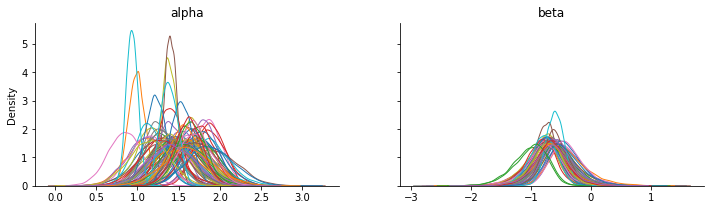

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=FIG_SIZE)
plot_kde(states_centered, "a", ax1)
plot_kde(states_centered, "b", ax2)
sns.despine()
ax1.set_title("alpha")
ax2.set_title("beta")

In [17]:
def plot_funnel_of_hell(x, sigma_x, k=75, ax=None):
    sns.set(style="whitegrid", font_scale=1.7)
    x = pd.Series(x[:, k].flatten(), name=f"slope b_{k}")
    y = pd.Series(sigma_x.flatten(), name="slope group variance sigma_b")

    return sns.jointplot(x=x, y=y, ylim=(0.0, 0.7), xlim=(-2.5, 1.0), color="blue", ax=ax, linewidth=0, s=12)

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


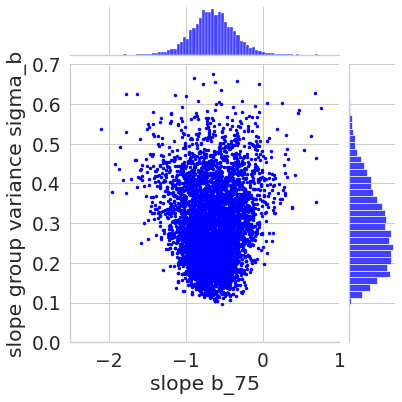

In [18]:
# fig, ax = plt.subplots()
samples_centered = states_centered.position
b_centered = samples_centered["b"]
sigma_b_centered = samples_centered["sigma_b"]

funnel_plt = plot_funnel_of_hell(b_centered, sigma_b_centered)
savefig("radonPosteriorCentered")

In [19]:
def plot_single_chain(x, sigma_x, name):
    fig, axs = plt.subplots(nrows=2, figsize=(16, 6))
    axs[0].plot(sigma_x, alpha=0.5)
    axs[0].set(ylabel=f"sigma_{name}")
    axs[1].plot(x, alpha=0.5)
    axs[1].set(ylabel=name);

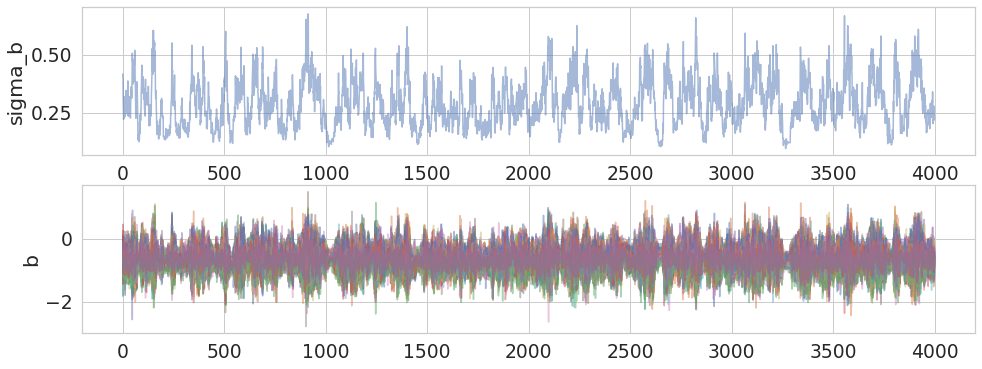

In [20]:
plot_single_chain(b_centered[1000:], sigma_b_centered[1000:], "b")

## Non-Centered Hierarchical Model

In [21]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
latexify(fig_height=2)
FIG_SIZE = None if is_latexify_enabled() else (12, 3)

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [22]:
params = states_non_centered.position

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


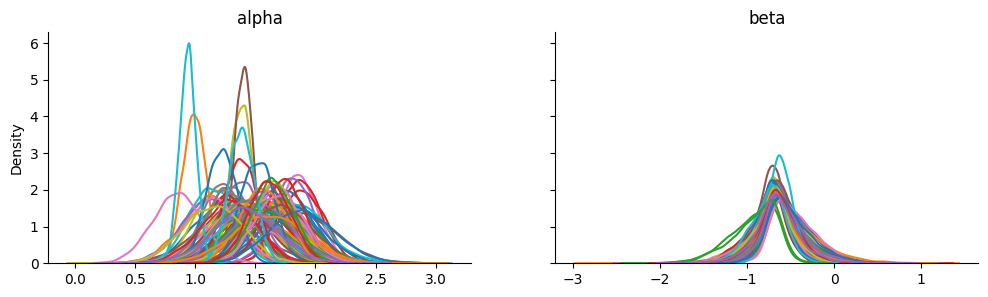

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=FIG_SIZE)
params = states_non_centered.position
for cnt in range(n_counties):
    a = params["mu_a"] + params["a_offsets"][:, cnt] * params["sigma_a"]
    b = params["mu_b"] + params["b_offsets"][:, cnt] * params["sigma_b"]
    sns.kdeplot(a, ax=ax1)
    sns.kdeplot(b, ax=ax2)
sns.despine()
ax1.set_title("alpha")
ax2.set_title("beta")
savefig("radonPosteriorsAlphaBeta_non_centered")

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


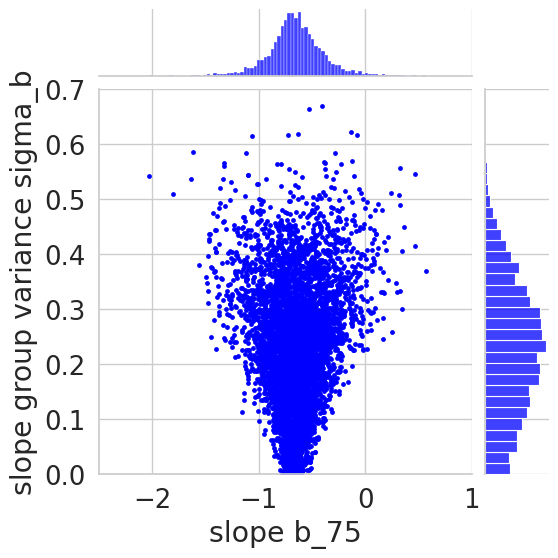

In [24]:
samples_non_centered = states_non_centered.position
b_non_centered = (
    samples_non_centered["mu_b"][..., None]
    + samples_non_centered["b_offsets"] * samples_non_centered["sigma_b"][..., None]
)
sigma_b_non_centered = samples_non_centered["sigma_b"]
plot_funnel_of_hell(b_non_centered, sigma_b_non_centered)
savefig("radonPosteriorUncentered")

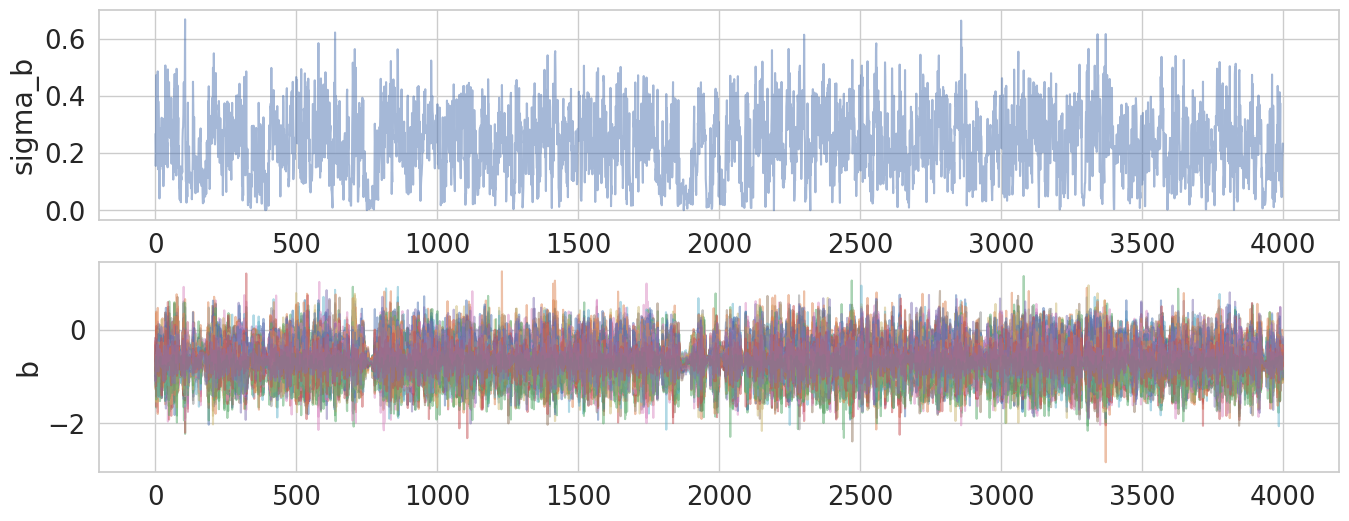

In [25]:
plot_single_chain(b_non_centered[1000:], sigma_b_non_centered[1000:], "b")

## Comparison

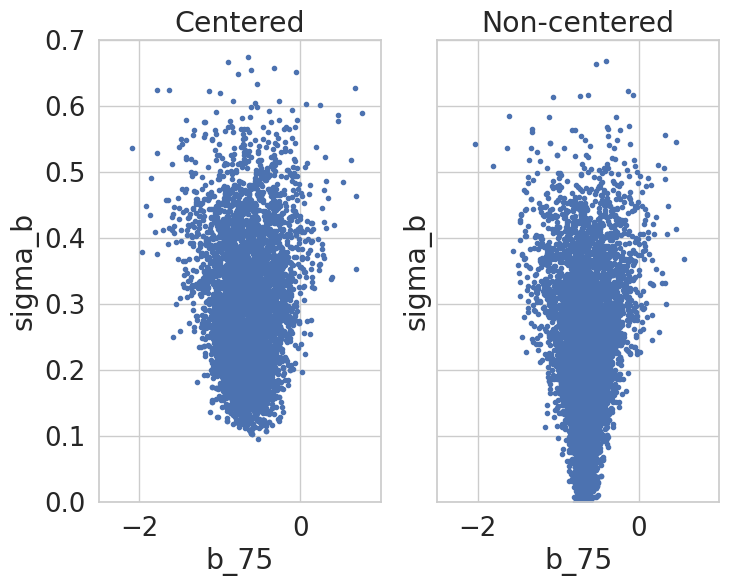

In [26]:
k = 75
x_lim, y_lim = [-2.5, 1], [0, 0.7]

bs = [(b_centered, sigma_b_centered, "Centered"), (b_non_centered, sigma_b_non_centered, "Non-centered")]
ncols = len(bs)

fig, axs = plt.subplots(ncols=ncols, sharex=True, sharey=True, figsize=(8, 6))

for i, (b, sigma_b, model_name) in enumerate(bs):
    x = pd.Series(b[:, k], name=f"slope b_{k}")
    y = pd.Series(sigma_b, name="slope group variance sigma_b")
    axs[i].plot(x, y, ".")
    axs[i].set(title=model_name, ylabel="sigma_b", xlabel=f"b_{k}")
    axs[i].set_xlim(x_lim)
    axs[i].set_ylim(y_lim)

## Non-hierarchical model

In [27]:
def init_param_non_hierarchical(rng_key):
    key1, key2, key3 = jax.random.split(rng_key, 3)
    params = {
        "a": tfd.Normal(0, 1).sample(seed=key1),
        "b": tfd.Normal(0, 1).sample(seed=key2),
        "eps": tfd.HalfCauchy(0, 1).sample(seed=key3),
    }
    return params

In [28]:
def log_joint_non_hierarchical(params, floor, log_radon):
    a = params["a"]  # alpha
    b = params["b"]  # beta
    eps = params["eps"]  # sigma noise
    log_joint = 0

    # prior
    log_joint += tfd.Normal(0, 1).log_prob(a)
    log_joint += tfd.Normal(0, 1).log_prob(b)
    log_joint += tfd.HalfCauchy(0, 1).log_prob(eps)

    # likelihood
    mu = a + b * floor
    log_joint += tfd.Normal(mu, eps).log_prob(log_radon).sum()
    return log_joint

In [29]:
def fit_non_hierarchical_model(floor, log_radon, num_warmup=1000, num_samples=5000, rng_key=jax.random.PRNGKey(0)):

    init_key, warmup_key, sample_key = jax.random.split(rng_key, 3)

    # warmup
    potential = partial(log_joint_non_hierarchical, floor=floor, log_radon=log_radon)
    warmup = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
    initial_position = init_param_non_hierarchical(init_key)
    initial_state, kernel, _ = warmup.run(warmup_key, initial_position)

    # inference
    states, info = inference_loop(sample_key, kernel, initial_state, num_samples)

    return states, info

In [30]:
selection = ["CASS", "CROW WING", "FREEBORN"]
indiv_params = {}
for country in selection:
    print(f"{country}...")
    c_data = data.loc[data.county == country]
    c_data = c_data.reset_index(drop=True)

    floor = jnp.array(c_data.floor.values)
    log_radon = jnp.array(c_data.log_radon)

    states, info = fit_non_hierarchical_model(floor, log_radon)
    indiv_params[country] = states.position

CASS...
CROW WING...
FREEBORN...


In [31]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
latexify(fig_height=2)
FIG_SIZE = None if is_latexify_enabled() else (12, 6)
FIG_SIZE

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


(12, 6)

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


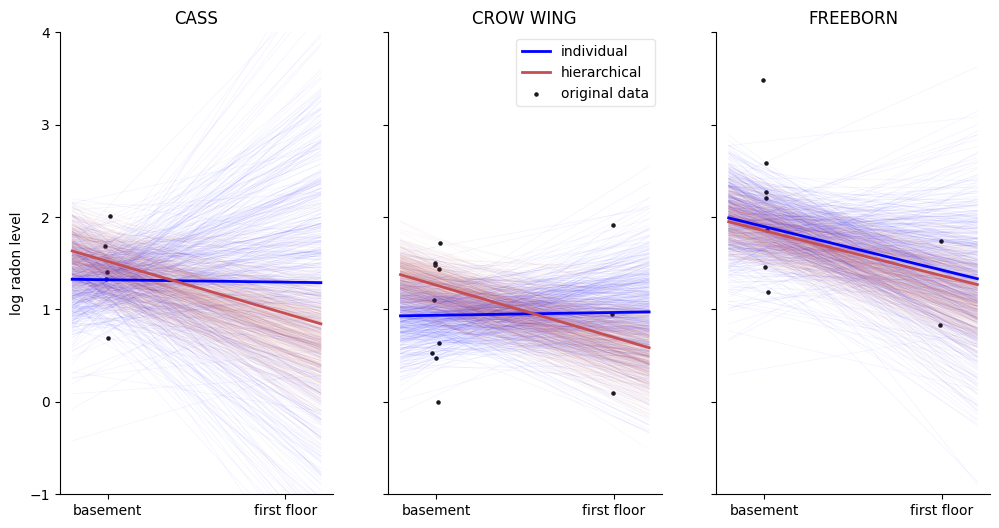

In [32]:
selection = ["CASS", "CROW WING", "FREEBORN"]
fig, axis = plt.subplots(1, 3, figsize=FIG_SIZE, sharey=True, sharex=True)
axis = axis.ravel()

for i, country in enumerate(selection):
    c_data = data.loc[data.county == country]
    c_data = c_data.reset_index(drop=True)
    county_code = list(c_data["county_code"])[0]
    xvals = np.linspace(-0.2, 1.2)

    # plots from samples of alpha and beta
    for a_val, b_val in zip(indiv_params[country]["a"][::10], indiv_params[country]["b"][::10]):
        axis[i].plot(xvals, a_val + b_val * xvals, alpha=0.05, lw=0.5, color="blue")

    # hierarchichal model - sample plots
    params = states_non_centered.position
    a = params["mu_a"] + params["a_offsets"][:, county_code] * params["sigma_a"]  # alpha
    b = params["mu_b"] + params["b_offsets"][:, county_code] * params["sigma_b"]  # beta

    for a_val, b_val in zip(a[::10], b[::10]):
        axis[i].plot(xvals, a_val + b_val * xvals, "r", alpha=0.05, lw=0.5)

    # non hierarchichal model - individual country plot
    axis[i].plot(
        xvals,
        indiv_params[country]["a"][::10].mean() + indiv_params[country]["b"][::10].mean() * xvals,
        alpha=1,
        lw=2.0,
        label="individual",
        color="blue",
    )

    # hierarchichal model - posterior mean
    axis[i].plot(
        xvals,
        a[::10][county_code].mean() + b[::10][county_code].mean() * xvals,
        "r",
        alpha=1,
        lw=2.0,
        label="hierarchical",
    )

    # original data
    axis[i].scatter(
        c_data.floor + np.random.randn(len(c_data)) * 0.01,
        c_data.log_radon,
        alpha=1,
        color="k",
        marker=".",
        s=20,
        label="original data",
    )
    axis[i].set_xticks([0, 1])
    axis[i].set_xticklabels(["basement", "first floor"])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(country)

sns.despine()
axis[1].legend(framealpha=0.5)
axis[0].set_ylabel("log radon level")
savefig("radonPredictions")